In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [2]:
name_dataset = 'kultura'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(51107, 7)
CPU times: user 5.96 s, sys: 143 ms, total: 6.1 s
Wall time: 6.11 s


In [4]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/gmn/,NaN,Мир,Плачидо Доминго стал арт-директором музыкально...,Всемирно известный итальянский тенор Плачидо Д...,Культура
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/bulgakov/,NaN,Россия,Академия художеств выбирает проект памятника Б...,В Москве на Патриарших прудах будет установлен...,Культура


### preprocess

* get dates

In [5]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


CPU times: user 237 ms, sys: 4.74 ms, total: 242 ms
Wall time: 241 ms


* clean text

In [6]:
import preprocessing_tools as pr

In [7]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 7.62 s, sys: 66.2 ms, total: 7.69 s
Wall time: 7.69 s


In [8]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/gmn/,NaN,Мир,Плачидо Доминго стал арт-директором музыкально...,всемирно известный итальянский тенор плачидо д...,Культура,"[(1999, 10, 01)]",1999,10
1,1999-10-07 12:00:00,https://lenta.ru/news/1999/10/07/bulgakov/,NaN,Россия,Академия художеств выбирает проект памятника Б...,в москве на патриарших прудах будет установлен...,Культура,"[(1999, 10, 07)]",1999,10


* cleanedNames

In [9]:
from cleanedNames import KeyProc
cn = KeyProc()

In [10]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 10s, sys: 32.3 ms, total: 1min 10s
Wall time: 1min 10s


* lemmatization

In [11]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 25s, sys: 190 ms, total: 2min 25s
Wall time: 2min 25s


* add docID

In [12]:
df['docID'] = list(range(df.shape[0]))

In [13]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[всемирно, известный, итальянский, тенор, плач..."
1,1,1999,10,"[москва, патриарший, пруд, установленный, памя..."


In [14]:
print(df.shape)
df.isnull().sum()

(51107, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [15]:
df.year.min()

1999

## model

* prepare

In [16]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 548 ms, sys: 64 ms, total: 612 ms
Wall time: 625 ms


In [17]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [18]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/kultura", num_batches=52)
CPU times: user 25.9 s, sys: 850 ms, total: 26.7 s
Wall time: 7.19 s


In [19]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [20]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=63abd20c-88fe-4f70-b830-97ce9607b59d, num_entries=30728)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [23]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.14731837809085846
	SparsityPhiScore: 0.2664761543273926
	PerplexityScore: 6182.146484375
	time: 0:01:09.303620
#topic 3.........
	SparsityThetaScore: 0.27503734827041626
	SparsityPhiScore: 0.4008632302284241
	PerplexityScore: 5355.8515625
	time: 0:01:16.564247
#topic 4.........
	SparsityThetaScore: 0.38498640060424805
	SparsityPhiScore: 0.47225451469421387
	PerplexityScore: 4843.9306640625
	time: 0:01:20.001234
#topic 5.........
	SparsityThetaScore: 0.44984835386276245
	SparsityPhiScore: 0.5142045021057129
	PerplexityScore: 4565.5927734375
	time: 0:01:23.815186
#topic 6.........
	SparsityThetaScore: 0.49802374839782715
	SparsityPhiScore: 0.5757639408111572
	PerplexityScore: 4303.5107421875
	time: 0:01:27.020111
#topic 7.........
	SparsityThetaScore: 0.5286387801170349
	SparsityPhiScore: 0.6167688369750977
	PerplexityScore: 4156.57568359375
	time: 0:01:29.008933
#topic 8.........
	SparsityThetaScore: 0.5476011037826538
	SparsityPhiScore: 0.658311

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

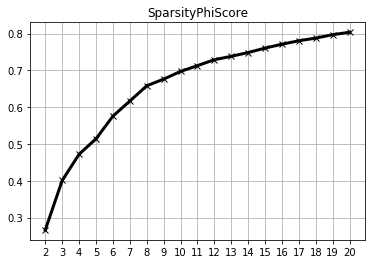

In [24]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [25]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

In [26]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 9, 0.8: 1}

Text(0.5, 1.0, 'SparsityThetaScore')

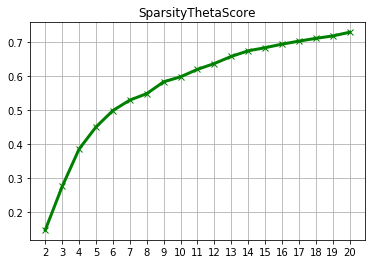

In [27]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [28]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [29]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 4, 0.6: 6, 0.7: 4}

Text(0.5, 1.0, 'PerplexityScore')

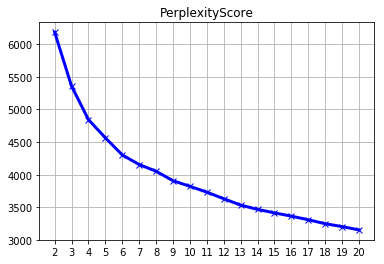

In [30]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [31]:
perplexity

[6182.146484375,
 5355.8515625,
 4843.9306640625,
 4565.5927734375,
 4303.5107421875,
 4156.57568359375,
 4053.708251953125,
 3908.640625,
 3823.334716796875,
 3733.690673828125,
 3633.373046875,
 3535.859375,
 3470.232421875,
 3416.7158203125,
 3366.642333984375,
 3311.54296875,
 3251.0771484375,
 3206.697998046875,
 3155.983642578125]

### select the best model

In [32]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.4: 2, 0.5: 2, 0.6: 4, 0.7: 9, 0.8: 1}
d_stheta: {0.1: 1, 0.2: 1, 0.3: 1, 0.4: 2, 0.5: 4, 0.6: 6, 0.7: 4}


In [33]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

20


---

In [21]:
select_topics = 20

model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# regularizers
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')

best_model = model.clone()


	SparsityThetaScore: 0.7317667007446289
	SparsityPhiScore: 0.8015035390853882
	PerplexityScore: 3187.0546875


---

### print top words for each topics

In [22]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['фестиваль' 'награда' 'номинация' 'церемония' 'приз' 'кинофестиваль'
 'вручение' 'программа' 'золотой' 'жюри']
topic_1: ['продать' 'аукцион' 'торг' 'фунт' 'выставить' 'продажа' 'стерлинг'
 'christie' 'стоимость' 'sotheby']
topic_2: ['студия' 'мультфильм' 'pictures' 'экран' 'серия' 'кинокомпания' 'disney'
 'комикс' 'персонаж' 'сценарий']
topic_3: ['музей' 'художник' 'выставка' 'галерея' 'современный' 'коллекция'
 'экспозиция' 'русский' 'открыться' 'представить']
topic_4: ['культура' 'решение' 'директор' 'министерство' 'министр' 'глава' 'письмо'
 'совет' 'власть' 'государственный']
topic_5: ['конкурс' 'музыкальный' 'евровидение' 'композитор' 'оркестр' 'фестиваль'
 'музыка' 'опера' 'дирижёр' 'певица']
topic_6: ['сериал' 'сезон' 'эпизод' 'канал' 'игра' 'серия' 'телеканал' 'ролик'
 'престол' 'сеть']
topic_7: ['коллектив' 'участник' 'гитарист' 'вокалист' 'музыкальный' 'rolling'
 'сольный' 'состав' 'бывший' 'певец']
topic_8: ['театр' 'спектакль' 'постановка' 'театральный' 'артист' '

In [32]:
# save to json

outjson = {}
# ---
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        #print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])
        outjson[f'{col}'] = phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20]

In [33]:
import pickle

with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'wb') as handle:
    pickle.dump(outjson, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open(f'''data/top20word/{'-'.join(name_dataset.split('.'))}.pickle''', 'rb') as handle:
    out_picle = pickle.load(handle)
    
out_picle

{'topic_0': array(['фестиваль', 'награда', 'номинация', 'церемония', 'приз',
        'кинофестиваль', 'вручение', 'программа', 'золотой', 'жюри',
        'категория', 'международный', 'кино', 'оскар', 'вручить',
        'лауреат', 'победитель', 'представить', 'конкурс', 'номинант'],
       dtype=object),
 'topic_1': array(['продать', 'аукцион', 'торг', 'фунт', 'выставить', 'продажа',
        'стерлинг', 'christie', 'стоимость', 'sotheby', 'аукционный',
        'художник', 'портрет', 'цена', 'полотно', 'сумма', 'дорогой',
        'владелец', 'лот', 'уйти'], dtype=object),
 'topic_2': array(['студия', 'мультфильм', 'pictures', 'экран', 'серия',
        'кинокомпания', 'disney', 'комикс', 'персонаж', 'сценарий',
        'киностудия', 'снять', 'warner', 'создатель', 'герой', 'трилогия',
        'marvel', 'сценарист', 'universal', 'франшиза'], dtype=object),
 'topic_3': array(['музей', 'художник', 'выставка', 'галерея', 'современный',
        'коллекция', 'экспозиция', 'русский', 'открыться

### get topics-docs matrix

shape theta: (20, 51067)


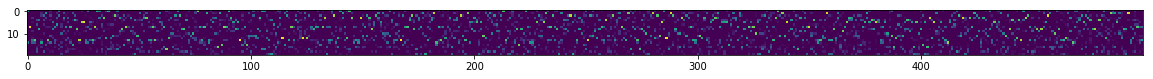

In [23]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [24]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
40000,0.135803,0.000000,0.026112,0.007716,0.134519,0.0,0.000000,0.000000,0.408715,0.0,0.000000,0.000000,0.080384,0.000000,0.000000,0.0,0.093325,0.000000,0.113426,0.0
40001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000479,0.000000,0.000000,0.0,0.379977,0.277133,0.000000,0.000000,0.000000,0.0,0.175674,0.057527,0.109210,0.0
40002,0.000000,0.000000,0.138698,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.338437,0.000000,0.000000,0.000000,0.0,0.000000,0.522866,0.000000,0.0
40003,0.000000,0.000000,0.173821,0.000000,0.000000,0.0,0.055421,0.090266,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.559687,0.0,0.000000,0.000000,0.120805,0.0
40004,0.000000,0.042668,0.069063,0.000000,0.037863,0.0,0.000000,0.000000,0.000000,0.0,0.469251,0.000000,0.000000,0.194784,0.136665,0.0,0.013406,0.036301,0.000000,0.0


## DataViz

In [25]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.438785,0.143952,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1,1999,10,0.0,0.000000,0.0,0.000000,0.074627,0.010812,0.000000,...,0.0,0.0,0.180562,0.0,0.0,0.0,0.0,0.0,0.280058,0.000000
2,2,1999,10,0.0,0.000000,0.0,0.068604,0.028178,0.000000,0.000000,...,0.0,0.0,0.491074,0.0,0.0,0.0,0.0,0.0,0.370526,0.000000
3,3,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.025450,0.702995
4,4,1999,10,0.0,0.065249,0.0,0.000000,0.210605,0.071945,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [26]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (227, 20)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 9      1.630274  0.038253  0.366227  1.037740  1.469666  0.559718   
     10     0.188645  1.034773  0.067860  0.935604  2.299511  1.339157   
     11     0.607137  1.240952  0.151408  0.801717  4.593189  0.066601   
     12     0.812545  0.423061  0.039731  3.278667  3.626335  0.806074   
2000 1      0.314056  1.275881  0.057516  1.291507  0.442988  0.145170   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 9      0.234594  0.027878  0.547676  1.419557  0.803937  0.347121   
     10     0.143952  0.341456  1.226097  1.886785  0.381023  0.000000   
     11     0.138923  0.000000  0.008567  1.573944  1.172009  0.571105   
     12     0.433786  0.238665  1.957175  2.047309  1.930427  0.051408   
2000 1      0.053713  0.000000  2.240125  1.110311  0.549037  0.000000   

            topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                               
1999 9      1.945520  0.326781  0.000000  0.020062  0.843780  0.087788   
     10     2.321607  0.374877  0.000000  0.000000  0.577257  0.010149   
     11     1.874379  0.000000  0.016485  0.415920  0.702369  0.138864   
     12     0.800894  0.674592  0.222349  0.032734  0.132533  0.000000   
2000 1      0.376612  0.204093  0.010449  0.050918  0.133986  0.514569   

            topic_18  topic_19  
year month                      
1999 9      0.416944  0.876483  
     10     1.114016  0.757231  
     11     0.810783  0.115648  
     12     1.031577  1.460137  
2000 1      0.860296  0.368773

### straightforward matrix heatmap

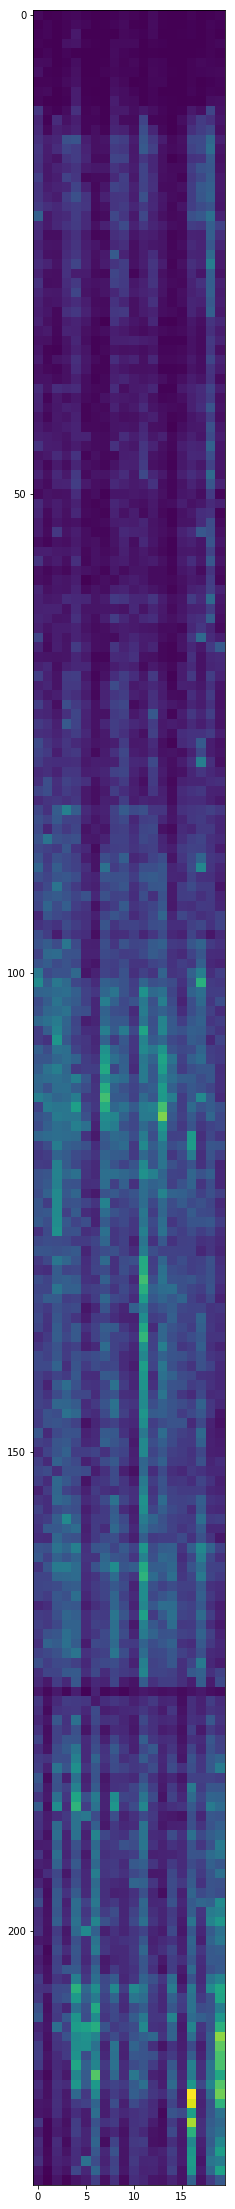

In [27]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [40]:
import pygal
from IPython.display import SVG, HTML

In [41]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [43]:
line_chart.render_to_file(f'data/visualization/{name_dataset}_pygal.svg')

## joypy

In [44]:
import joypy # !pip install joypy

In [28]:
print(joined.shape)
joined.head()

(51107, 23)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,0,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.438785,0.143952,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,1,1999,10,0.0,0.000000,0.0,0.000000,0.074627,0.010812,0.000000,...,0.0,0.0,0.180562,0.0,0.0,0.0,0.0,0.0,0.280058,0.000000
2,2,1999,10,0.0,0.000000,0.0,0.068604,0.028178,0.000000,0.000000,...,0.0,0.0,0.491074,0.0,0.0,0.0,0.0,0.0,0.370526,0.000000
3,3,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.025450,0.702995
4,4,1999,10,0.0,0.065249,0.0,0.000000,0.210605,0.071945,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [29]:
joined.to_csv(f'''./data/topicsProbability/{'-'.join(name_dataset.split('.'))}.csv''',index=False)

In [46]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year_month
0,0,0,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1999-10-01
1,1,1,1999,10,0.0,0.000000,0.0,0.000000,0.059196,0.010513,...,0.0,0.207493,0.0,0.0,0.0,0.0,0.0,0.245232,0.018071,1999-10-01
2,2,2,1999,10,0.0,0.000000,0.0,0.084223,0.025833,0.000000,...,0.0,0.462890,0.0,0.0,0.0,0.0,0.0,0.345718,0.081335,1999-10-01
3,3,3,1999,10,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.023920,0.714705,1999-10-01
4,4,4,1999,10,0.0,0.024062,0.0,0.000000,0.195096,0.099675,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1999-10-01


In [47]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1226568, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [48]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(1022140, 3)


topic_14    51107
topic_18    51107
topic_3     51107
topic_11    51107
topic_12    51107
topic_8     51107
topic_10    51107
topic_5     51107
topic_7     51107
topic_6     51107
topic_17    51107
topic_19    51107
topic_1     51107
topic_0     51107
topic_2     51107
topic_15    51107
topic_16    51107
topic_13    51107
topic_9     51107
topic_4     51107
Name: topic, dtype: int64

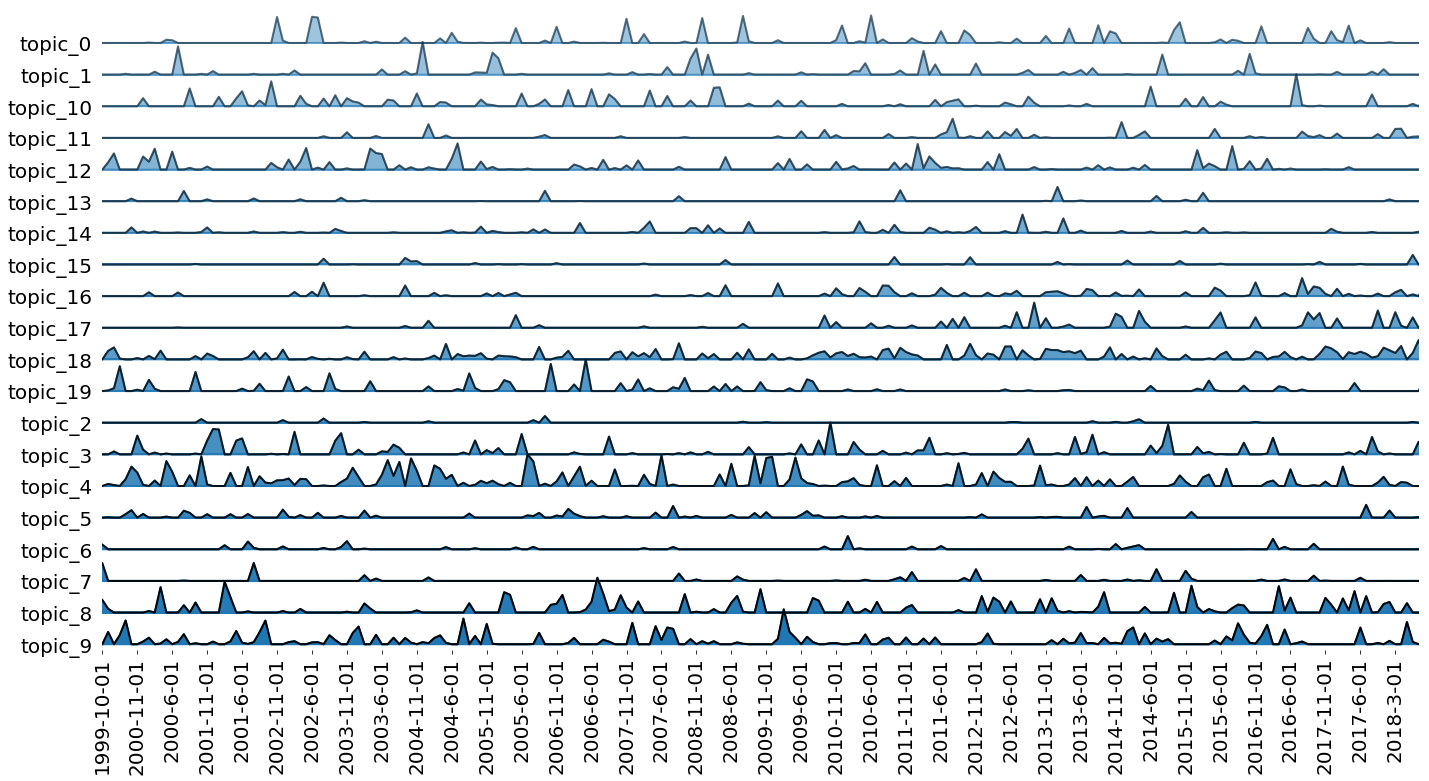

In [49]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [50]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")